# Cardiovascular study predictive modelling

## Introduction
The purpose of this notebook is to analyse [Cardiovascular Study Dataset](https://www.kaggle.com/datasets/christofel04/cardiovascular-study-dataset-predict-heart-disea) and predict whether patient have 10 year risk of coronary heart disease CHD or not. The linera regression model shall be used to make predictions.

### Data Description

* **Sex**: male or female("M" or "F")
* **Age**: Age of the patient;(Continuous - Although the recorded ages have been truncated to whole numbers, the concept of age is continuous)

* **is_smoking**: whether or not the patient is a current smoker ("YES" or "NO")
* **Cigs Per Day**: the number of cigarettes that the person smoked on average in one day.(can be considered continuous as one can have any number of cigarettes, even half a cigarette.)

* **BP Meds**: whether or not the patient was on blood pressure medication (Nominal)
* **Prevalent Stroke**: whether or not the patient had previously had a stroke (Nominal)
* **Prevalent Hyp**: whether or not the patient was hypertensive (Nominal)
* **Diabetes**: whether or not the patient had diabetes (Nominal)

* **Tot Chol**: total cholesterol level (Continuous)
* **Sys BP**: systolic blood pressure (Continuous)
* **Dia BP**: diastolic blood pressure (Continuous)
* **BMI**: Body Mass Index (Continuous)
* **Heart Rate**: heart rate (Continuous - In medical research, variables such as heart rate though in fact discrete, yet are considered continuous because of large number of possible values.)
* **Glucose**: glucose level (Continuous)

Predict variable (desired target):
* **10 year risk of coronary heart disease CHD**(binary: “1”, means “Yes”, “0” means “No”)

### **The structure of the notebook**:

0. Initialization
1. Data loading and cleaning.
2. Exploratory Data Analysis.
3. Data prediction modelling.

## 0. Initialization

In [51]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from mlxtend.feature_selection import SequentialFeatureSelector
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import os

for dirname, _, filenames in os.walk("/kaggle/input"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/train.csv
/kaggle/input/test.csv


In [52]:
df = pd.read_csv(
    "/kaggle/input/train.csv"
)
df.shape

(3390, 17)

## 1. Data loading and cleaning

In [53]:
df.head()

,id,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,0,64,2.0,F,YES,3.0,0.0,0,0,0,221.0,148.0,85.0,NaN,90.0,80.0,1
1,1,36,4.0,M,NO,0.0,0.0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0
2,2,46,1.0,F,YES,10.0,0.0,0,0,0,250.0,116.0,71.0,20.35,88.0,94.0,0
3,3,50,1.0,M,YES,20.0,0.0,0,1,0,233.0,158.0,88.0,28.26,68.0,94.0,1
4,4,64,1.0,F,YES,30.0,0.0,0,0,0,241.0,136.5,85.0,26.42,70.0,77.0,0


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3390 entries, 0 to 3389
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               3390 non-null   int64  
 1   age              3390 non-null   int64  
 2   education        3303 non-null   float64
 3   sex              3390 non-null   object 
 4   is_smoking       3390 non-null   object 
 5   cigsPerDay       3368 non-null   float64
 6   BPMeds           3346 non-null   float64
 7   prevalentStroke  3390 non-null   int64  
 8   prevalentHyp     3390 non-null   int64  
 9   diabetes         3390 non-null   int64  
 10  totChol          3352 non-null   float64
 11  sysBP            3390 non-null   float64
 12  diaBP            3390 non-null   float64
 13  BMI              3376 non-null   float64
 14  heartRate        3389 non-null   float64
 15  glucose          3086 non-null   float64
 16  TenYearCHD       3390 non-null   int64  
dtypes: float64(9),

Since we have 2 objects (non-numerical values) here, we shall transfrom them to numerical later,so to be able to make correlation calculations.

In [55]:
df.isna().sum()

id                   0
age                  0
education           87
sex                  0
is_smoking           0
cigsPerDay          22
BPMeds              44
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             38
sysBP                0
diaBP                0
BMI                 14
heartRate            1
glucose            304
TenYearCHD           0
dtype: int64

Check if there is no duplicated data.

In [56]:
df.duplicated().mean()

0.0

In [57]:
# Before Altering the Data copying orinal data
df_copy=df.copy()

drop_na = df.dropna()
drop_na.shape

(2927, 17)

Having in mind the missing data is less than 14%, insted of deleting data, we shall replace the missing values with approximate values.

**Glucose**

Since Glucose median is close to the mean, we are replacing missing values with the median.

In [58]:
df['glucose'].describe()

count    3086.000000
mean       82.086520
std        24.244753
min        40.000000
25%        71.000000
50%        78.000000
75%        87.000000
max       394.000000
Name: glucose, dtype: float64

In [59]:
#fillind the missing values with the median
print('Glucose Feature Missing Before')
print(df_copy[['glucose']].isnull().sum())
print('--'*50)

df_copy['glucose']=df_copy['glucose'].fillna(df_copy['glucose'].median())

print(df_copy[['glucose']].isnull().sum())

Glucose Feature Missing Before
glucose    304
dtype: int64
----------------------------------------------------------------------------------------------------
glucose    0
dtype: int64


In [60]:
print(df_copy[['glucose']].isna().sum())

glucose    0
dtype: int64


**Education**

Education feature is not a continues variable so we using Mode for filling the missing values

In [61]:
print("Education Feature Missing Before")
print(df_copy[["education"]].isnull().sum())
print("--" * 50)

df_copy["education"] = df_copy["education"].fillna(
    df_copy["education"].mode()[0]
)
print("Education Feature Missing After")
print(df_copy[["education"]].isnull().sum())
print("--" * 50)

Education Feature Missing Before
education    87
dtype: int64
----------------------------------------------------------------------------------------------------
Education Feature Missing After
education    0
dtype: int64
----------------------------------------------------------------------------------------------------


**BPMeds**

BPMeds have only 0 and 1 values, which means binary system. So filling NAs by mode.

In [62]:
df['BPMeds'].describe()

count    3346.000000
mean        0.029886
std         0.170299
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: BPMeds, dtype: float64

In [63]:
print("BPMeds Feature Missing Before")
print(df_copy[["BPMeds"]].isnull().sum())
print("--" * 50)
df_copy["BPMeds"] = df_copy["BPMeds"].fillna(df_copy["BPMeds"].mode()[0])
print("BPMeds Feature Missing After")
print(df_copy[["BPMeds"]].isnull().sum())
print("--" * 50)

BPMeds Feature Missing Before
BPMeds    44
dtype: int64
----------------------------------------------------------------------------------------------------
BPMeds Feature Missing After
BPMeds    0
dtype: int64
----------------------------------------------------------------------------------------------------


**Total Cholostral**
The median is close to mean again, so filling in NAs with median value.

In [64]:
df['totChol'].isna().sum()

38

In [65]:
print("Total colostrol Feature Missing Before")
print(df_copy[["totChol"]].isnull().sum())
print("--" * 50)
df_copy["totChol"] = df_copy["totChol"].fillna(df_copy["totChol"].median())
print("Total colostrol Feature Missing After")
print(df_copy[["totChol"]].isnull().sum())
print("--" * 50)

Total colostrol Feature Missing Before
totChol    38
dtype: int64
----------------------------------------------------------------------------------------------------
Total colostrol Feature Missing After
totChol    0
dtype: int64
----------------------------------------------------------------------------------------------------


**Cigrates per Day**

In [66]:
df['cigsPerDay'].isna().sum()

22

In [67]:
print("Cigars per day Feature Missing Before")
print(df_copy[["cigsPerDay"]].isnull().sum())
print("--" * 50)
df_copy["cigsPerDay"] = df_copy["cigsPerDay"].fillna(
    df_copy["cigsPerDay"].median()
)
print("Cigars per day Feature Missing After")
print(df_copy[["cigsPerDay"]].isnull().sum())
print("--" * 50)

Cigars per day Feature Missing Before
cigsPerDay    22
dtype: int64
----------------------------------------------------------------------------------------------------
Cigars per day Feature Missing After
cigsPerDay    0
dtype: int64
----------------------------------------------------------------------------------------------------


**Body Mass Index(BMI)**

In [68]:
df['BMI'].describe()

count    3376.000000
mean       25.794964
std         4.115449
min        15.960000
25%        23.020000
50%        25.380000
75%        28.040000
max        56.800000
Name: BMI, dtype: float64

In [69]:
print('BMI Feature Missing Before')
print(df_copy[['BMI']].isnull().sum())
print('--'*50)
df_copy['BMI']=df_copy['BMI'].fillna(df['BMI'].median())
print('BMI Feature Missing After')
print(df_copy[['BMI']].isnull().sum())
print('--'*50)

BMI Feature Missing Before
BMI    14
dtype: int64
----------------------------------------------------------------------------------------------------
BMI Feature Missing After
BMI    0
dtype: int64
----------------------------------------------------------------------------------------------------


**Heart Rate**

In [70]:
df['heartRate'].isna().sum()

1

In [71]:
print('Heart Rate Feature Missing Before')
print(df_copy[['heartRate']].isnull().sum())
print('--'*50)
df_copy['heartRate']=df_copy['heartRate'].fillna(df['heartRate'].median())
print('Heart Rate Feature Missing After')
print(df_copy[['heartRate']].isnull().sum())
print('--'*50)

Heart Rate Feature Missing Before
heartRate    1
dtype: int64
----------------------------------------------------------------------------------------------------
Heart Rate Feature Missing After
heartRate    0
dtype: int64
----------------------------------------------------------------------------------------------------


In [72]:
df_copy.isna().sum()

id                 0
age                0
education          0
sex                0
is_smoking         0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

- Let's make sure we can include sex and is_smoking type to calculations as well.

In [73]:
# Converting the 'sex' column from object to int64
# 1 stands for M, 0 stands for F

df_copy['sex'] = df_copy['sex'].map({'M': 1, 'F': 0}).astype('int64')
df_copy['sex'].head(), df_copy['sex'].dtype

(0    0
 1    1
 2    0
 3    1
 4    0
 Name: sex, dtype: int64,
 dtype('int64'))

In [74]:
df_copy["is_smoking"] = (
    df_copy["is_smoking"].map({"YES": 1, "NO": 0}).astype("int64")
)
df_copy["is_smoking"].head(), df_copy["is_smoking"].dtype

(0    1
 1    0
 2    1
 3    1
 4    1
 Name: is_smoking, dtype: int64,
 dtype('int64'))

In [75]:
#drop ID which has no use in this analysis
df_copy.drop(['id'],axis=1,inplace=True)
df_copy.head()

,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,64,2.0,0,1,3.0,0.0,0,0,0,221.0,148.0,85.0,25.38,90.0,80.0,1
1,36,4.0,1,0,0.0,0.0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0
2,46,1.0,0,1,10.0,0.0,0,0,0,250.0,116.0,71.0,20.35,88.0,94.0,0
3,50,1.0,1,1,20.0,0.0,0,1,0,233.0,158.0,88.0,28.26,68.0,94.0,1
4,64,1.0,0,1,30.0,0.0,0,0,0,241.0,136.5,85.0,26.42,70.0,77.0,0


## 2. Exploratory Data Analysis.

In this part I shall start from taking a look at the dependend variable and then move on with classification to prepare the for prediction modelling.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


TenYearCHD
0    2879
1     511
Name: count, dtype: int64

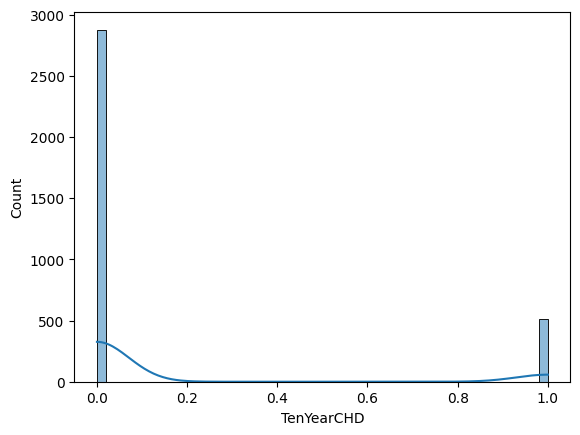

In [76]:
sns.histplot(df.TenYearCHD, bins=50, kde=True)
df_copy["TenYearCHD"].value_counts()

Let's see the correlations between variables

/tmp/ipykernel_345/2562356418.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_copy.hist(ax = ax)


array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'education'}>,
        <Axes: title={'center': 'sex'}>,
        <Axes: title={'center': 'is_smoking'}>],
       [<Axes: title={'center': 'cigsPerDay'}>,
        <Axes: title={'center': 'BPMeds'}>,
        <Axes: title={'center': 'prevalentStroke'}>,
        <Axes: title={'center': 'prevalentHyp'}>],
       [<Axes: title={'center': 'diabetes'}>,
        <Axes: title={'center': 'totChol'}>,
        <Axes: title={'center': 'sysBP'}>,
        <Axes: title={'center': 'diaBP'}>],
       [<Axes: title={'center': 'BMI'}>,
        <Axes: title={'center': 'heartRate'}>,
        <Axes: title={'center': 'glucose'}>,
        <Axes: title={'center': 'TenYearCHD'}>]], dtype=object)

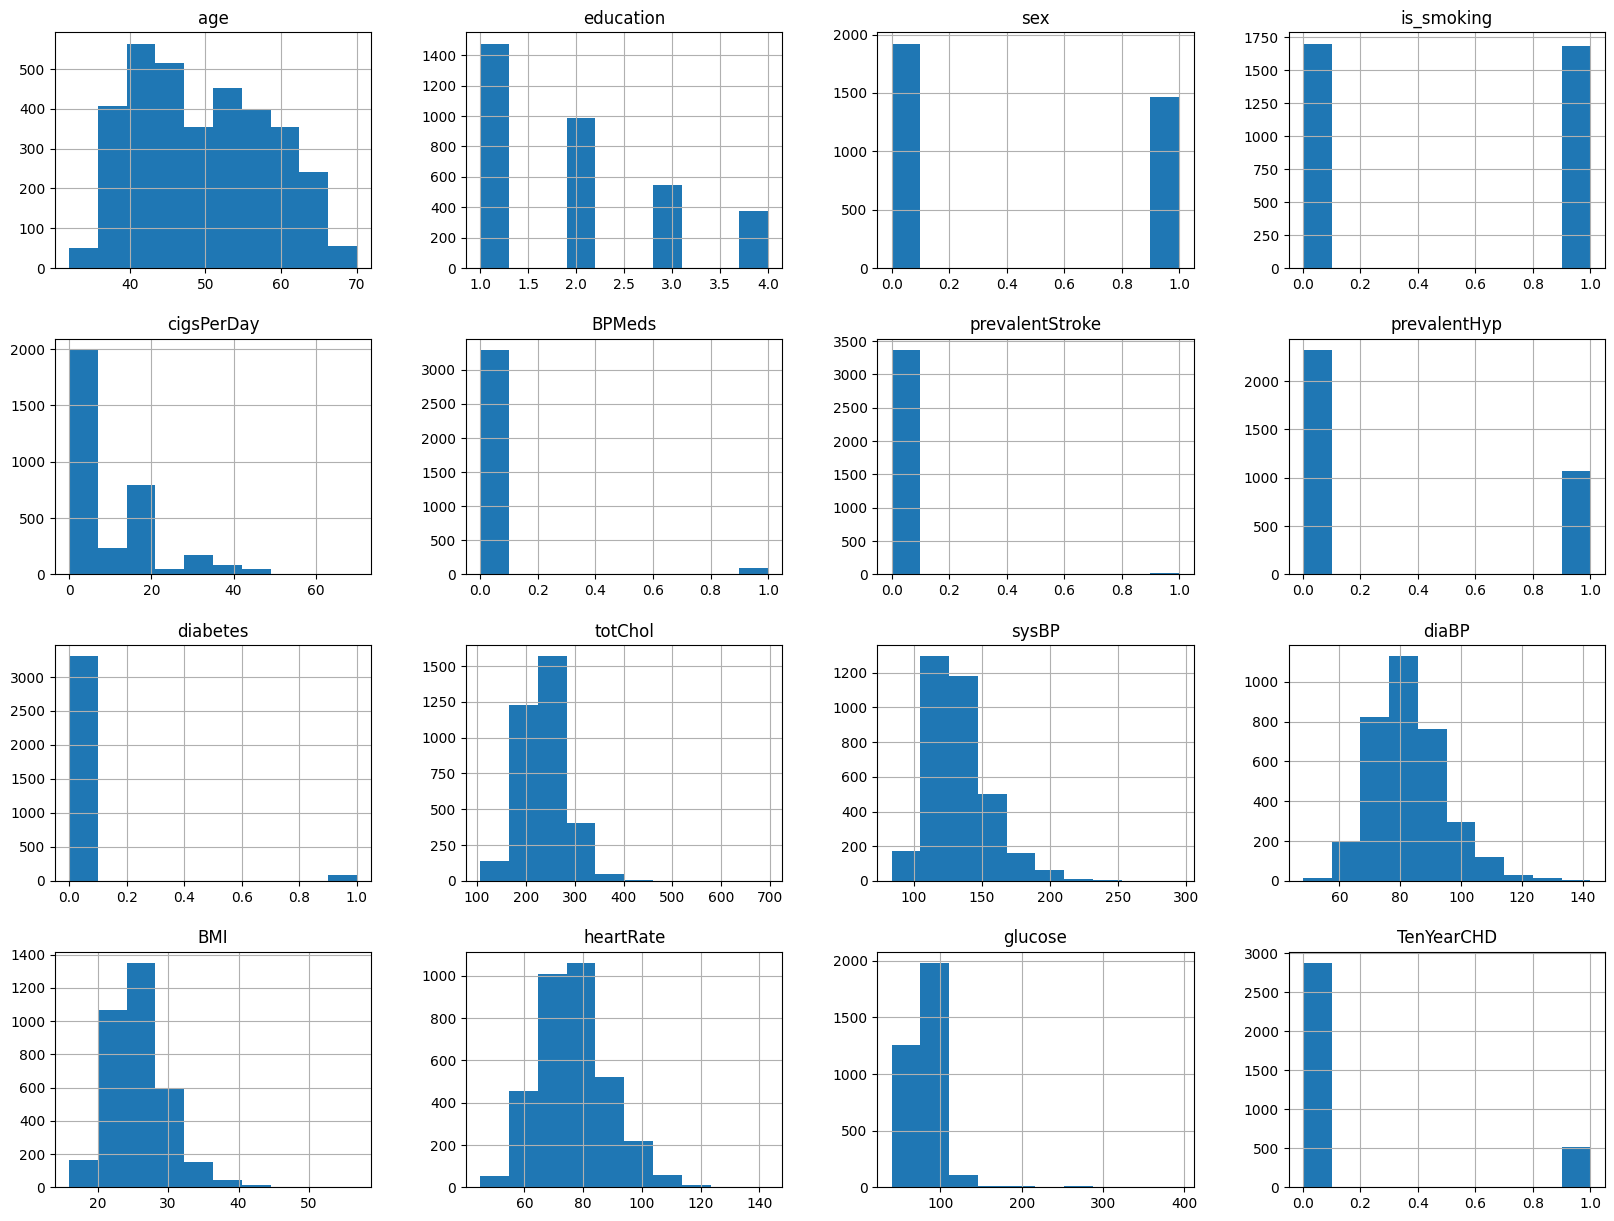

In [77]:
fig = plt.figure(figsize = (20,15))
ax = fig.gca()
df_copy.hist(ax = ax)

For the further analysis we shall drop some features which have no significant impact for the results:
- prevalentStroke - there are no stroke cases.

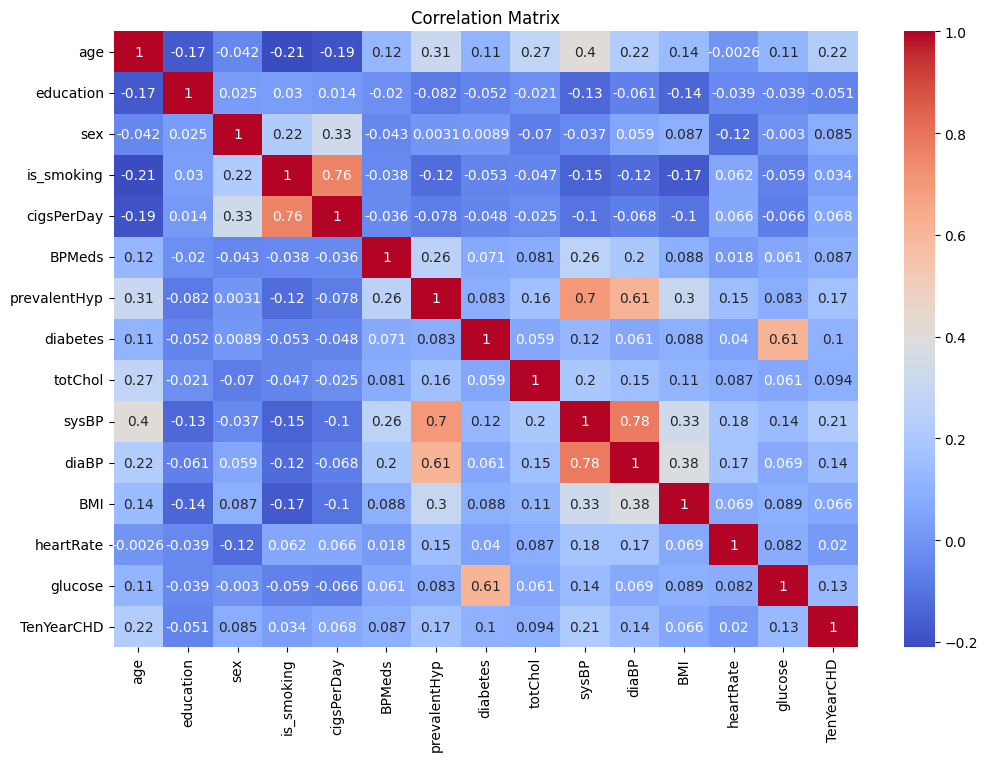

In [78]:
# List of features and target variable
features = [
    "age",
    "education",
    "sex",
    "is_smoking",
    "cigsPerDay",
    "BPMeds",
    "prevalentHyp",
    "diabetes",
    "totChol",
    "sysBP",
    "diaBP",
    "BMI",
    "heartRate",
    "glucose",
]
target = "TenYearCHD"

correlation_matrix = df_copy[features + [target]].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

The highest correlations are between diabetes and glucose,sysBP and diaBP, sysBP and prevelantHYP.

We can see that the risk of CHD does not strongly correlate with any one of the features. The strongest correlations are 0.22 and 0.21 with age and sysBP. But these do not help making any conclusions yet.

In [79]:
df_copy["prevalentHyp"].value_counts()

prevalentHyp
0    2321
1    1069
Name: count, dtype: int64

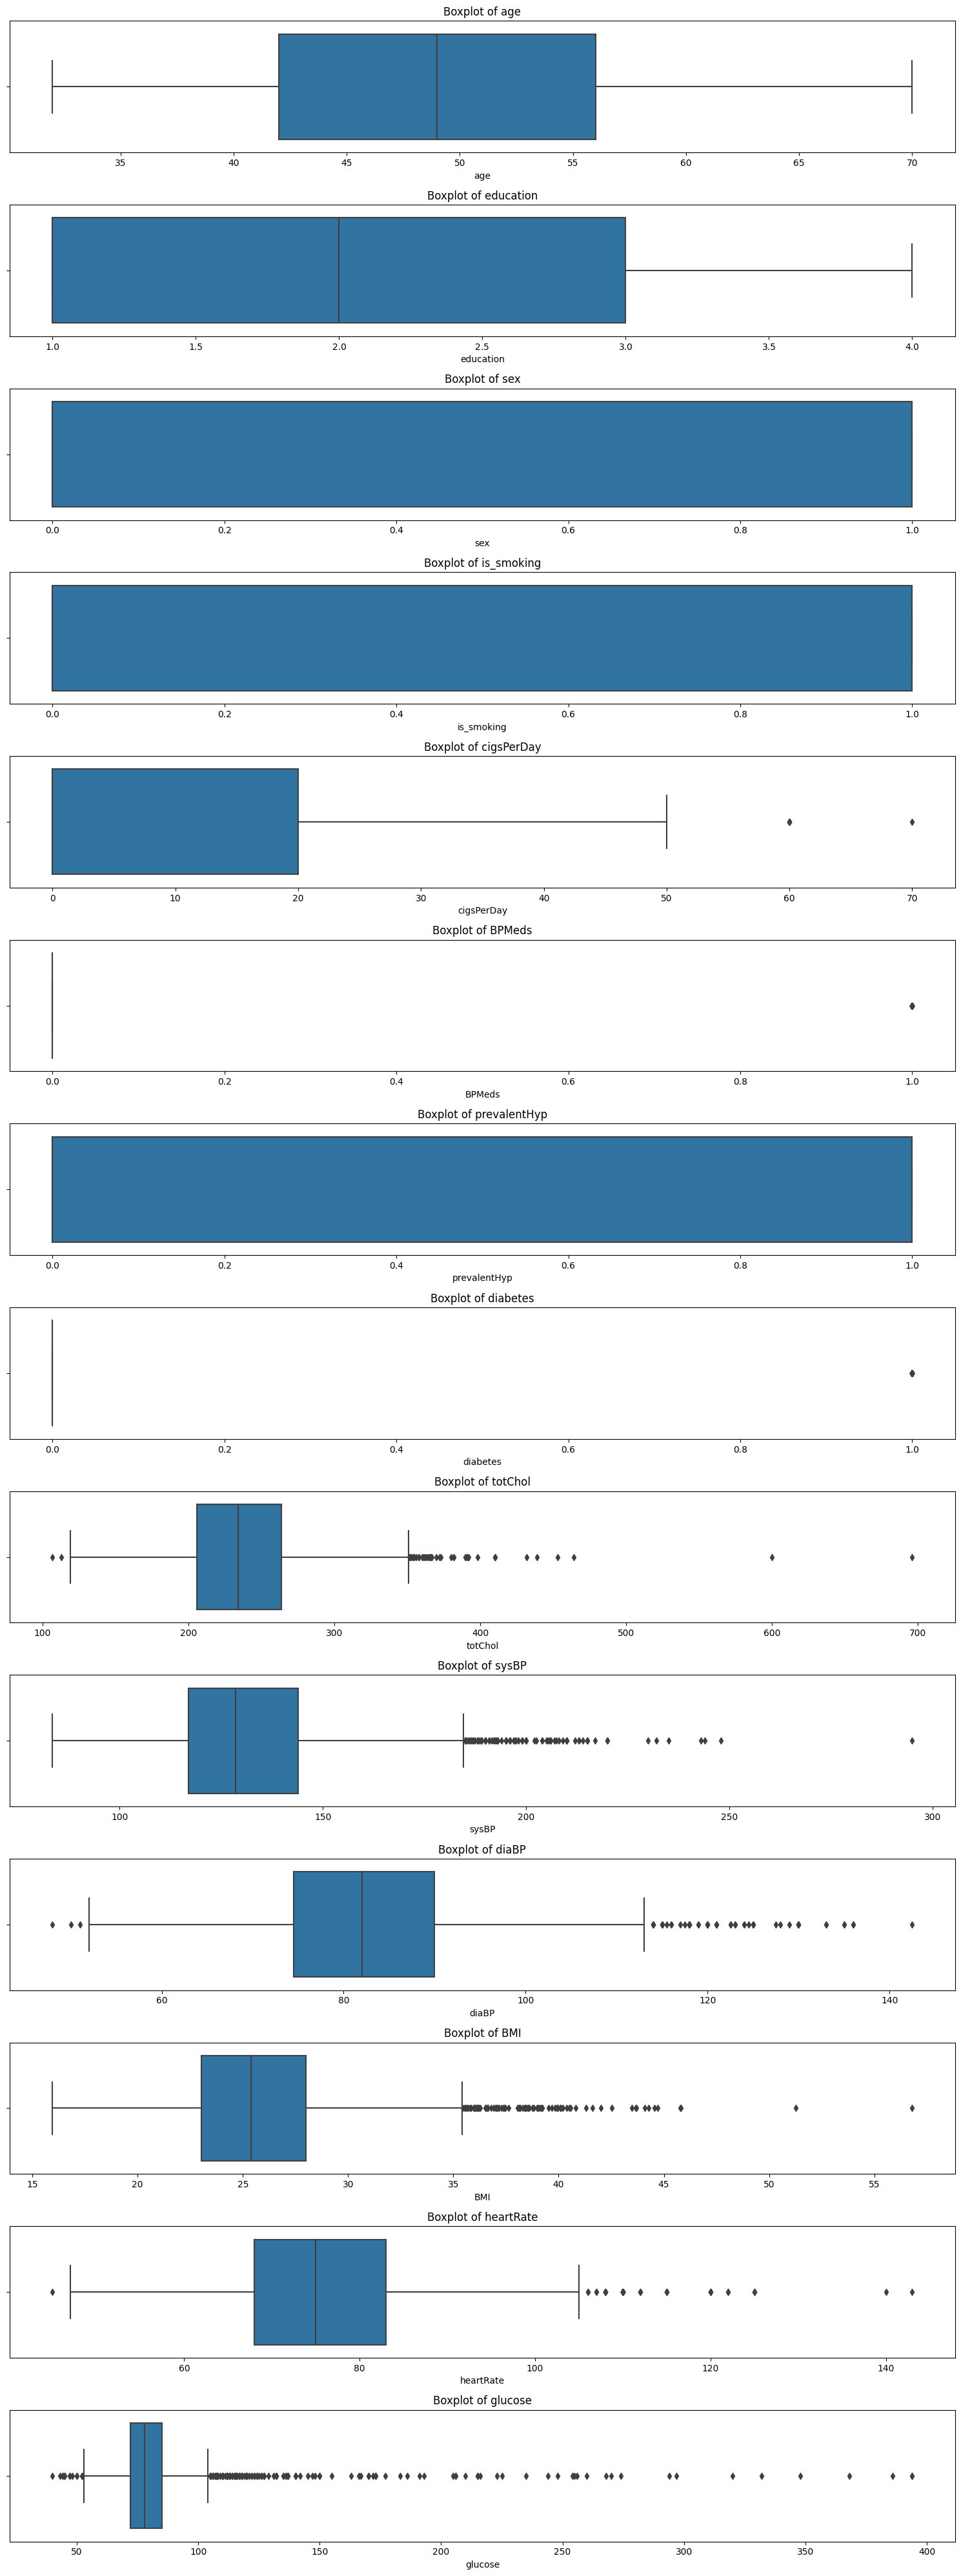

In [80]:
plt.figure(figsize=(15, 40))

num_features = len(features)

for i, feature in enumerate(features):
    plt.subplot(num_features, 1, i + 1)
    sns.boxplot(data=df_copy, x=feature)
    plt.title(f'Boxplot of {feature}')
    plt.tight_layout()

plt.show()

From the boxplots we can see that some specific features have a lot of outliers which need to be double-checked and cleaned out.
Since there are multiple features with possible outliers, we need a defined function for that.

In [81]:
# Define a function to detect outliers using the IQR method
def detect_outliers_iqr(df_copy):
    outliers = {}

    for column in df_copy.columns:
        if pd.api.types.is_numeric_dtype(df_copy[column]):
            Q1 = df_copy[column].quantile(0.25)
            Q3 = df_copy[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            outlier_count = df_copy[
                (df_copy[column] < lower_bound)
                | (df_copy[column] > upper_bound)
            ].shape[0]
            outliers[column] = outlier_count

    return outliers

In [82]:
outliers = detect_outliers_iqr(df_copy)

outliers_df = pd.DataFrame(
    list(outliers.items()), columns=["Feature", "Number of Outliers"]
)
outliers_df

,Feature,Number of Outliers
0,age,0
1,education,0
2,sex,0
3,is_smoking,0
4,cigsPerDay,9
5,BPMeds,100
6,prevalentStroke,22
7,prevalentHyp,0
8,diabetes,87
9,totChol,43


Defining function for removing outliers.

In [83]:
def remove_outliers_iqr(df_copy):
    df_clean = df_copy.copy()
    
    for column in df_clean.columns:
        if pd.api.types.is_numeric_dtype(df_clean[column]):
            Q1 = df_clean[column].quantile(0.25)
            Q3 = df_clean[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            # Remove outliers
            df_clean = df_clean[
                (df_clean[column] >= lower_bound) &
                (df_clean[column] <= upper_bound)
            ]
    
    return df_clean

In [84]:
df_clean = remove_outliers_iqr(df_copy)

print(f"Original dataset shape: {df_copy.shape}")
print(f"Dataset shape after removing outliers: {df_clean.shape}")

Original dataset shape: (3390, 16)
Dataset shape after removing outliers: (2431, 16)


Unfortunately, by removing all outliers with the IQR method we lost about 30% of dataset, which might diminish the statistical value of the dataset.
So, I will use different methods for each feature. cigsPerDay - IQR method fits fine as there are not much outliers.

Sensitivity of the Model: Some models (like linear regression) are highly sensitive to outliers, which can disproportionately influence the results. In such cases, removing or capping outliers can improve model robustness.

In [85]:
def cap_outliers(df_copy, lower_percentile=0.01, upper_percentile=0.99):
    df_capped = (
        df_copy.copy()
    )  # Make a copy of the DataFrame to avoid modifying the original data

    for column in df_capped.columns:
        if pd.api.types.is_numeric_dtype(df_capped[column]):
            lower_bound = df_capped[column].quantile(lower_percentile)
            upper_bound = df_capped[column].quantile(upper_percentile)

            # Cap the values at the lower and upper bounds
            df_capped[column] = np.where(
                df_capped[column] < lower_bound, lower_bound, df_capped[column]
            )
            df_capped[column] = np.where(
                df_capped[column] > upper_bound, upper_bound, df_capped[column]
            )

    return df_capped

In [86]:
df_capped = cap_outliers(df_copy)

print(f"Original dataset shape: {df_copy.shape}")
print(f"Dataset shape after capping outliers: {df_capped.shape}")

print("Statistics before capping outliers:")
print(df_copy.describe())
print("\nStatistics after capping outliers:")
print(df_capped.describe())

Original dataset shape: (3390, 16)
Dataset shape after capping outliers: (3390, 16)
Statistics before capping outliers:
               age    education          sex   is_smoking   cigsPerDay  \
count  3390.000000  3390.000000  3390.000000  3390.000000  3390.000000   
mean     49.542183     1.946018     0.432743     0.497640     9.010619   
std       8.592878     1.017568     0.495529     0.500068    11.862839   
min      32.000000     1.000000     0.000000     0.000000     0.000000   
25%      42.000000     1.000000     0.000000     0.000000     0.000000   
50%      49.000000     2.000000     0.000000     0.000000     0.000000   
75%      56.000000     3.000000     1.000000     1.000000    20.000000   
max      70.000000     4.000000     1.000000     1.000000    70.000000   

            BPMeds  prevalentStroke  prevalentHyp     diabetes      totChol  \
count  3390.000000      3390.000000   3390.000000  3390.000000  3390.000000   
mean      0.029499         0.006490      0.315339     0

## 3. Data prediction modelling

Since there is no clear answer which

In [87]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

In [88]:
# Scaling the features (optional but often recommended for models like KNN)
scaler = StandardScaler()

In [89]:
# Splitting data into train and test datasets
X = df_capped.drop('TenYearCHD', axis=1)
y = df_capped['TenYearCHD']

In [90]:
X_scaled = scaler.fit_transform(X)
skf = StratifiedKFold(n_splits=5)

In [91]:
# Initialize models
logreg = LogisticRegression(max_iter=10000)
dtc = DecisionTreeClassifier()
knn = KNeighborsClassifier(n_neighbors=5)
rf = RandomForestClassifier(n_estimators=100, random_state=42)

In [92]:
models = {
    'Logistic Regression': logreg,
    'Decision Tree': dtc,
    'KNN': knn,
    'Random Forest': rf
}

In [93]:
# Create an empty list to store the evaluation scores
model_scores = []

# Iterate over the models and calculate evaluation metrics using cross-validation
for model_name, model in models.items():
    precision_scores = []
    recall_scores = []
    f1_scores = []
    roc_auc_scores = []

    for train_index, test_index in skf.split(X_scaled, y):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Fit the model
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)
        y_pred_prob = model.predict_proba(X_test)[:, 1]

        # Calculate metrics
        precision_scores.append(precision_score(y_test, y_pred))
        recall_scores.append(recall_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))
        roc_auc_scores.append(roc_auc_score(y_test, y_pred_prob))

    # Append the mean scores for each metric
    model_scores.append({
        "Model": model_name,
        "Precision": sum(precision_scores) / len(precision_scores),
        "Recall": sum(recall_scores) / len(recall_scores),
        "F1-Score": sum(f1_scores) / len(f1_scores),
        "ROC AUC Score": sum(roc_auc_scores) / len(roc_auc_scores)
    })

In [94]:
# Convert the list of model scores to a DataFrame
df_scores = pd.DataFrame(model_scores)

# Print the DataFrame with the evaluation scores
print(df_scores)

                 Model  Precision    Recall  F1-Score  ROC AUC Score
0  Logistic Regression   0.618491  0.068570  0.122205       0.724087
1        Decision Tree   0.255100  0.287740  0.269971       0.569012
2                  KNN   0.304693  0.078260  0.124272       0.621144
3        Random Forest   0.482727  0.054826  0.097454       0.688861



* While LR has good precision and ROC AUC, the model is not picking up enough true positives, leading to low recall and F1-score.
* Decision Tree offers a better balance between precision and recall, but it still struggles with ROC AUC, suggesting it's not capturing patterns well.
* Random Forest has decent precision and ROC AUC, but it fails to capture true positives effectively, leading to poor recall and F1-Score.
* KNN isn’t performing well. Its recall is too low, meaning it's missing most of the true positives.


**Model Selection**:

Decision Tree stands out with the best F1-Score of 0.265, which is higher than the others. While the score is still low, it's better compared to Logistic Regression, KNN, and Random Forest.
The Random Forest and Logistic Regression models perform poorly on F1-Score, despite Random Forest being a more powerful model. KNN also has a relatively low F1-Score.

## 4. Decision tree model

In [97]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Hyperparameter grids
param_grid_logreg = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear']
}

param_grid_dtc = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'metric': ['euclidean', 'manhattan'],
    'weights': ['uniform', 'distance']
}

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'max_features': ['auto', 'sqrt']
}

# Add class_weight='balanced' to Logistic Regression and Decision Tree
logreg = LogisticRegression(max_iter=10000, class_weight='balanced')
dtc = DecisionTreeClassifier(class_weight='balanced')
rf = RandomForestClassifier(class_weight='balanced')

# Define RandomizedSearchCV instead of GridSearchCV
random_logreg = RandomizedSearchCV(LogisticRegression(max_iter=10000), 
                                   param_distributions=param_grid_logreg, 
                                   n_iter=10, cv=5, scoring='f1', random_state=42)
random_dtc = RandomizedSearchCV(DecisionTreeClassifier(), 
                                param_distributions=param_grid_dtc, 
                                n_iter=10, cv=5, scoring='f1', random_state=42)
random_knn = RandomizedSearchCV(KNeighborsClassifier(), 
                                param_distributions=param_grid_knn, 
                                n_iter=10, cv=5, scoring='f1', random_state=42)
random_rf = RandomizedSearchCV(RandomForestClassifier(random_state=42), 
                               param_distributions=param_grid_rf, 
                               n_iter=10, cv=5, scoring='f1', random_state=42)

# Fit models (fewer iterations, faster)
random_logreg.fit(X_scaled, y)
random_dtc.fit(X_scaled, y)
random_knn.fit(X_scaled, y)
random_rf.fit(X_scaled, y)

# Print best parameters and scores
print("Best parameters for Logistic Regression:", random_logreg.best_params_)
print("Best F1-score for Logistic Regression:", random_logreg.best_score_)

print("Best parameters for Decision Tree:", random_dtc.best_params_)
print("Best F1-score for Decision Tree:", random_dtc.best_score_)

print("Best parameters for KNN:", random_knn.best_params_)
print("Best F1-score for KNN:", random_knn.best_score_)

print("Best parameters for Random Forest:", random_rf.best_params_)
print("Best F1-score for Random Forest:", random_rf.best_score_)

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.p

Best parameters for Logistic Regression: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 1}
Best F1-score for Logistic Regression: 0.122204739742575
Best parameters for Decision Tree: {'min_samples_split': 2, 'max_depth': 30, 'criterion': 'entropy'}
Best F1-score for Decision Tree: 0.27526257252620606
Best parameters for KNN: {'weights': 'distance', 'n_neighbors': 3, 'metric': 'manhattan'}
Best F1-score for KNN: 0.18118222823773636
Best parameters for Random Forest: {'n_estimators': 100, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': None}
Best F1-score for Random Forest: 0.11864897795063242


Classification Report:
               precision    recall  f1-score   support

         0.0       0.87      0.91      0.89       581
         1.0       0.28      0.22      0.24        97

    accuracy                           0.81       678
   macro avg       0.58      0.56      0.57       678
weighted avg       0.79      0.81      0.80       678

ROC AUC Score: 0.5989761697748284


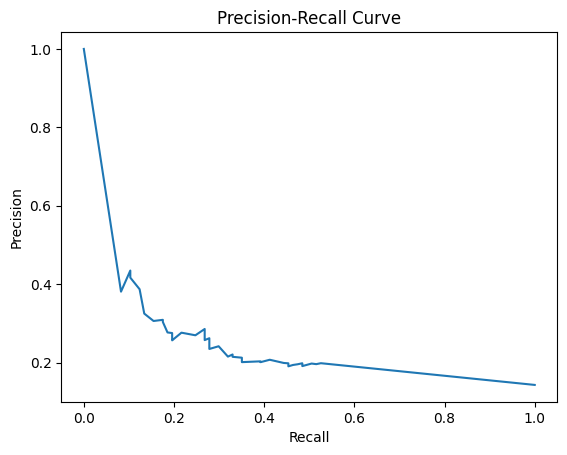

In [98]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve
from sklearn.model_selection import train_test_split

# Use the best hyperparameters for Decision Tree
best_dtc = DecisionTreeClassifier(min_samples_split=20, max_depth=None, criterion='gini')

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train the model
best_dtc.fit(X_train, y_train)

# Make predictions
y_pred = best_dtc.predict(X_test)
y_pred_prob = best_dtc.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_prob))

# Plot Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

**Key Observations**:
The model is biased towards the majority class (class 0), which is common in imbalanced datasets.
Precision and recall for class 1 are very low, indicating the model is not effectively predicting the minority class (class 1).

In [99]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report

# Split original data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training data only
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Train the Decision Tree model on the resampled data
best_dtc = DecisionTreeClassifier(min_samples_split=20, max_depth=None, criterion='gini')
best_dtc.fit(X_resampled, y_resampled)

# Make predictions on the test set
y_pred = best_dtc.predict(X_test)
y_pred_prob = best_dtc.predict_proba(X_test)[:, 1]

# Evaluate the model's performance
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_prob))

# Optional: If you want to adjust the threshold
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.82      0.85       581
         1.0       0.23      0.33      0.27        97

    accuracy                           0.75       678
   macro avg       0.55      0.57      0.56       678
weighted avg       0.79      0.75      0.76       678

ROC AUC Score: 0.5931650016856823


**After applying SMOTE**, the classification report shows some improvement in the recall for class 1 (minority class) but there is still a significant gap in performance between the two classes. Here’s what the results indicate:

**Key Observations**:

Class 0 (Majority Class):

* Precision: 0.88 – The model is still very accurate in predicting the majority class.
* Recall: 0.82 – Slight drop from the previous result, but still high.
* F1-Score: 0.85 – Overall, good balance for class 0.

Class 1 (Minority Class):

* Precision: 0.23 – Relatively low, meaning many false positives (predicting class 1 when it's actually class 0).
* Recall: 0.33 – Improved recall, up from 0.22 before SMOTE, meaning the model is now identifying more true positives for class 1.
* F1-Score: 0.27 – Slight improvement in the F1-Score, but still low, indicating an ongoing struggle to balance precision and recall for class 1.
* Overall Accuracy: 0.75 – This dropped slightly, which is expected after applying SMOTE, as the model is now focusing more on the minority class.

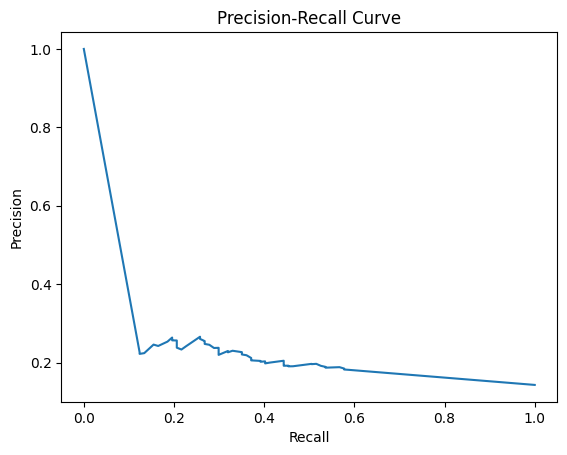

In [101]:
from sklearn.metrics import precision_recall_curve

# Get predicted probabilities from the model
y_pred_prob = best_dtc.predict_proba(X_test)[:, 1]

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

# Plot Precision-Recall Curve
import matplotlib.pyplot as plt
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Adjust the threshold
optimal_threshold = 0.3  # Example, set threshold based on curve analysis
y_pred_adjusted = (y_pred_prob >= optimal_threshold).astype(int)

After applying SMOTE, the classification report shows some improvement in the recall for class 1 (minority class) but there is still a significant gap in performance between the two classes.

Overall Accuracy: 0.75 – This dropped slightly, which is expected after applying SMOTE, as the model is now focusing more on the minority class.

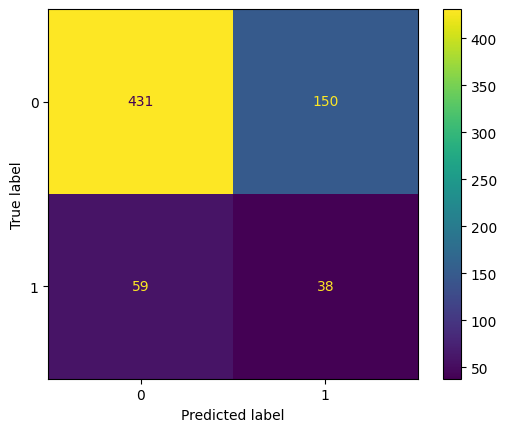

[[431 150]
 [ 59  38]]


In [102]:
cm = confusion_matrix(y_test, y_pred_adjusted)  # or y_pred if threshold tuning wasn't applied

# Plot confusion matrix
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()

print(cm)

The model is performing well for the majority class (433 TN), but it is struggling with the minority class (class 1).
There are 148 false positives, which means the model is overpredicting class 1.
There are 60 false negatives, indicating that the model is missing many class 1 cases (important in imbalanced datasets).
The 37 true positives show that the model is identifying some minority class cases, but there’s room for improvement.

Checking the best features and applying them to the model.

## Conclusion

The dataset contains two classes: class 0 (majority class) and class 1 (minority class), with a significant class imbalance (581 samples for class 0 and 97 samples for class 1).
Class imbalance poses a challenge for machine learning models, as they tend to focus on correctly predicting the majority class, which can lead to poor performance on the minority class.

**Model Performance**:
Initial models (Logistic Regression, Decision Tree, KNN, and Random Forest) showed relatively poor F1-scores, particularly for the minority class (class 1). This was due to a focus on maximizing accuracy and precision for class 0, while neglecting class 1.
Best F1-scores:
Decision Tree: 0.27 for class 1 (best model for the minority class).
Logistic Regression, KNN, and Random Forest struggled to balance precision and recall for class 1.

**Solution to the class imbalance**:

Applying SMOTE helped to balance the dataset by generating synthetic samples for class 1. This improved recall for class 1, though precision remained low, indicating ongoing challenges with predicting minority class cases accurately.
The Decision Tree model improved slightly after SMOTE, with recall for class 1 increasing to 0.33, although precision for class 1 was still relatively low (0.23).
Confusion Matrix Analysis:

**The confusion matrix after applying SMOTE showed**:
433 True Negatives (TN) for class 0: The model is still highly accurate for the majority class.
148 False Positives (FP): The model predicted class 1 incorrectly for many class 0 instances.
60 False Negatives (FN): The model missed many class 1 instances, indicating that true positive identification for class 1 is still challenging.
37 True Positives (TP): Only 37 out of 97 true class 1 samples were correctly identified.
Areas for Improvement:

**Minority Class Prediction**: The model struggles to identify class 1 (the minority class), with relatively low recall and precision. Despite SMOTE, the model still has a high number of false negatives, meaning many actual class 1 cases are missed.

**Threshold Tuning**: Adjusting the decision threshold could help improve the balance between precision and recall for class 1, potentially improving F1-score and reducing false negatives.
Model Complexity: More complex models, such as Gradient Boosting or XGBoost, may be able to capture more complex relationships in the data and improve minority class prediction.
Feature Engineering: Improving the quality of the features through selection or engineering could lead to better model performance, especially in distinguishing between the two classes.